# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

### definitions

In [12]:
ChlToN=1.8
rundict={'202007H':'/home/sallen/202007/202007H',
         '202007I':'/home/sallen/202007/202007I',
         '202007J':'/home/sallen/202007/202007J',
         '201812':'/results/SalishSea/nowcast-green.201812/',
         '201905':'/results2/SalishSea/nowcast-green.201905/'}
namfmt={'202007H':'long',
        '202007I':'long',
        '202007J':'long',
        '201812':'nowcast',
        '201905':'nowcast'}
tres={'202007H':24,
      '202007I':24,
      '202007J':24,
      '201812':1,
      '201905':24}
cols={'202007H':'c',
      '202007I':'g',
      '202007J':'k',
      '201812':'b',
      '201905':'m'}
startdate=dt.datetime(2015,2,1)
enddate=dt.datetime(2015,3,30)
yearstr='2015'
len(rundict)

5

### load ferry data

In [3]:
df1=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20140804T234330Z_20150604T070614Z-clean.csv',
        skiprows=78,usecols=['TimeUTC','Chlorophyll_ug','ChlQC','Lat','LatQC','Lon','LongQC'],header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'),
               dtype={'TimeUTC':str,'Chlorophyll_ug':str,'ChlQC':int,'Lat':str,'LatQC':int,
                      'Lon':str,'LongQC':int})
df2=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
        skiprows=78,usecols=['TimeUTC','Chlorophyll_ug','ChlQC','Lat','LatQC','Lon','LongQC'],header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'),
               dtype={'TimeUTC':str,'Chlorophyll_ug':str,'ChlQC':int,'Lat':str,'LatQC':int,
                      'Lon':str,'LongQC':int})
df=pd.concat([df1.drop(df1[df1.TimeUTC<yearstr].index),df2.drop(df2[df2.TimeUTC>'2016'].index)],ignore_index=True)
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]
df=df.assign(dts=dts)
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')
df['Chlorophyll_ug']=pd.to_numeric(df['Chlorophyll_ug'],errors='coerce')
df.head()

,TimeUTC,Chlorophyll_ug,ChlQC,Lat,LatQC,Lon,LongQC,dts
0,2015-01-01T00:00:08.461Z,1.2463,1,49.094471,8,-123.426450,8,2015-01-01 00:00:08
1,2015-01-01T00:00:17.515Z,1.2342,1,49.094835,8,-123.427538,8,2015-01-01 00:00:17
2,2015-01-01T00:00:27.689Z,1.2221,1,49.095233,8,-123.428714,8,2015-01-01 00:00:27
3,2015-01-01T00:00:37.874Z,1.3673,1,49.095742,8,-123.429833,8,2015-01-01 00:00:37
4,2015-01-01T00:00:48.048Z,1.2826,1,49.096250,8,-123.430950,8,2015-01-01 00:00:48


(16436.0, 16679.0)

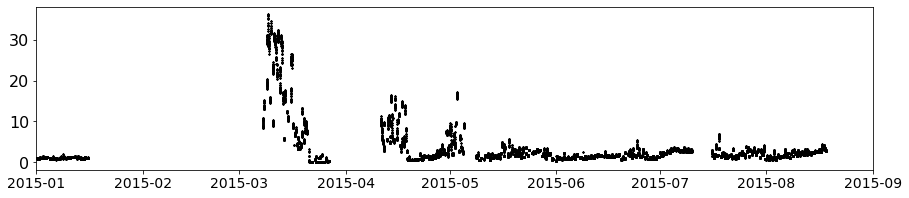

In [4]:
ij,ii=places.PLACES['S3']['NEMO grid ji']
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'k*',ms=2)
ax.set_xlim(dt.datetime(2015,1,1),dt.datetime(2015,9,1))

In [5]:
diat=dict()
myri=dict()
nano=dict()
tt=dict()
for key in rundict:
    print(key,dt.datetime.now())
    fin=et.index_model_files(startdate,enddate,rundict[key],namfmt[key],1,'ptrc_T',tres[key])
    fobj=xr.open_mfdataset(fin['paths'])
    tt[key]=fobj.time_centered if 'time_centered' in fobj.coords else fobj.time_counter
    diat[key]=fobj.diatoms.isel(deptht=slice(0,3),y=ij,x=ii).mean(dim='deptht').compute()
    myri[key]=fobj.ciliates.isel(deptht=slice(0,3),y=ij,x=ii).mean(dim='deptht').compute()
    nano[key]=fobj.flagellates.isel(deptht=slice(0,3),y=ij,x=ii).mean(dim='deptht').compute()
    fobj.close()

202007H 2021-09-13 08:21:17.204377
202007I 2021-09-13 08:22:05.392018
202007J 2021-09-13 08:22:49.108396
201812 2021-09-13 08:23:24.201813
201905 2021-09-13 08:40:33.700062


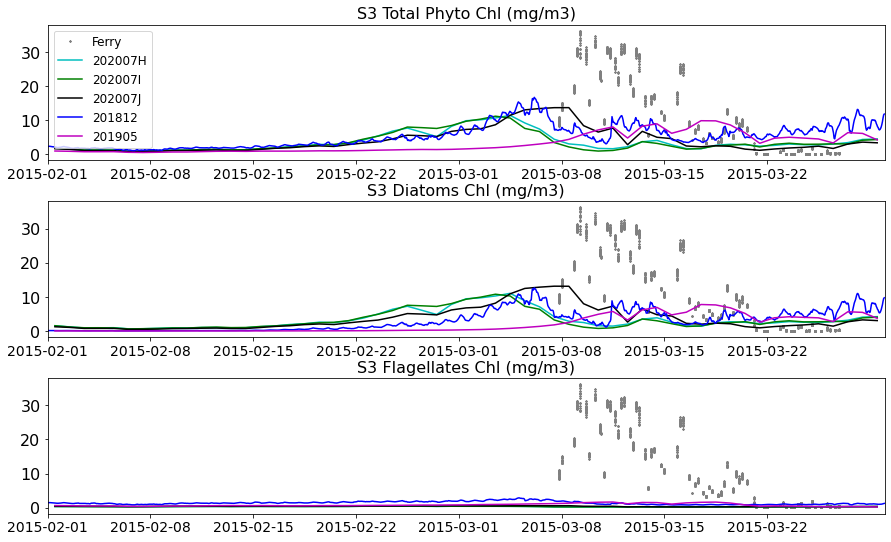

In [13]:
ChlToN=1.8
fig,ax=plt.subplots(3,1,figsize=(15,3*3))
fig.subplots_adjust(hspace=.3)
for iax in ax:
    iax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'*',ms=2,color='gray',label='Ferry')
    iax.set_xlim(startdate,enddate)
for key in rundict:
    ax[0].plot(tt[key],ChlToN*(diat[key]+myri[key]+nano[key]),'-',color=cols[key],label=key)
    ax[1].plot(tt[key],ChlToN*(diat[key]),'-',color=cols[key],label=key)
    ax[2].plot(tt[key],ChlToN*(nano[key]),'-',color=cols[key],label=key)
    ax[0].set_title('S3 Total Phyto Chl (mg/m3)')
    ax[1].set_title('S3 Diatoms Chl (mg/m3)')
    ax[2].set_title('S3 Flagellates Chl (mg/m3)')
ax[0].legend(fontsize=12)